Muitas vezes as pessoas dizem que modelos de machine learning são "caixas pretas", que eles tem boas decisões mas que não é claro como eles chegam nessas decisões.Em muitos casos, explicar como um modelo de machine learning tomou uma decisão especifica é muito importante, caso por exemplo você tenha uma empresa de crédito que usa um modelo de machine learning para decidir se você vai ou não conceder um empréstimo para um cliente. Você entra com os dados do cliente no modelo, que devolve um resultado dizendo para não conceder o empréstimo ao cliente. Daí o cliente pode te questionar, por que não lhe foi concedido o empréstimo. Nesse caso, seria muito importante você saber para aquele caso específico, como foi que o seu modelo chegou nesta decisão.

Para construir o modelo de machine learning, usamos o LightGBM, que é um framework de gradient boosting baseado em algoritmos de árvore de decisão.
Como funciona uma Árvore de Decisão?
Supondo que queremos prever o risco de conceder crédito a um cliente de uma fintech, então vamos utilizar essa pequena base de dados como exemplo.

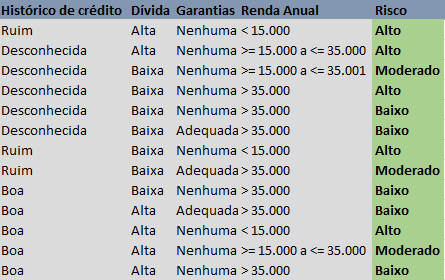

O objetivo é analisar essa base de dados histórica e saber qual é o Risco de conceder o crédito para um determinado cliente através desses atributos: Histórico de Crédito, Dívida, Garantia e Renda Anual.
Uma árvore de decisão geralmente começa com um único nó que se divide em possíveis resultados e cada um desses resultados levam a nós adicionais que ramificam em outras possibilidades criando assim uma árvore.

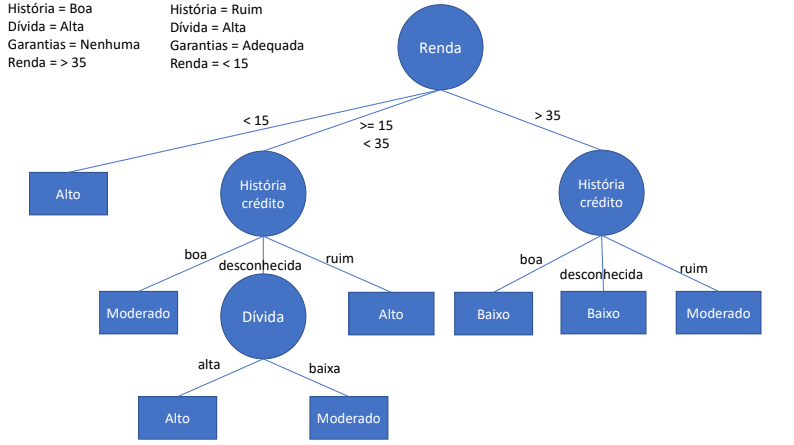

Como funciona o LightGBM?

O LightGBM é um algoritmo de gradient boosting, que é uma técnica de machine learning para problemas de regressão e classificação, ele produz um modelo de previsão na forma de um ensemble de modelos de previsão fracos, geralmente árvores de decisão. Sendo uma junção de várias árvores de decisão, ele se torna um modelo forte.
Algumas características do LightGBM são:
 * Velocidade de treino mais rápida, e com mais eficiência.
 * Menor us de memória.
 * Acurácia maior.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import random, math

import warnings
warnings.simplefilter(action='ignore')

Definição de Seed para deixar o trabalho determinístico

In [2]:
SEED = 99
random.seed(SEED)
np.random.seed(SEED)

### Load do dataset
Carregando os dados na memória

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')

In [4]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [5]:
dfmodel = df.copy()

In [6]:
dfmodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
# Leio as colunas que tem tipo "object" e uso o labelEncoder para transformar os valores
for col in dfmodel.columns[dfmodel.dtypes == 'object']:
    le = LabelEncoder()
    le.fit(dfmodel[col])
    dfmodel[col] = le.transform(dfmodel[col])

# Defino quais são os atributos categóricos e transformo o seu tipo para "categoria"
category = ['job','marital','education','default','housing','loan','poutcome']
for col in category :
    dfmodel[col] = dfmodel[col].astype('category')

In [8]:
dfmodel.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [9]:
dfmodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null int32
day          45211 non-null int64
month        45211 non-null int32
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
y            45211 non-null int32
dtypes: category(7), int32(3), int64(7)
memory usage: 3.2 MB


In [10]:
X = dfmodel.drop(['y'], axis = 1)
y = dfmodel.y

Defino os hiperparâmetros que serão usados pelo modelo

In [11]:
lgb_params = {
                    'objective':'binary',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05,
                    'num_leaves': 20,
                    'max_depth':-1,
                    'subsample':0.9,
                    'n_estimators':1500,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                }

Realizo o treino do modelo, utilizando a técnica de validação cruzada com Kfold, podendo assim saber se a métrica de avaliação do modelo está boa, mesmo sem ter dados específicos para validação ou teste. Escolhi a métrica de avaliação AUC pois para problemas de classificação com o alvo da predição desbalanceado, é uma métrica mais robusta que diz de forma mais assertiva a real qualidade do modelo

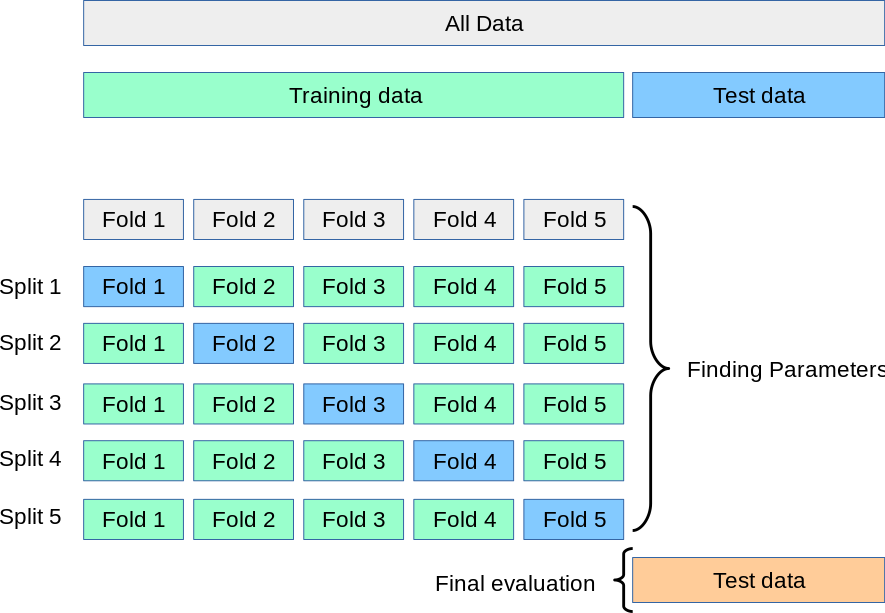

In [12]:
# Esolho o numero de folds e crio uma variável para coletar o valor AUC de cada fold
K = 5
folds = KFold(K, shuffle = True, random_state = SEED)
best_scorecv= 0

# Faço a separação dos dados por folds, crio os dataframes de treino e de validação, treino o modelo e calculo a média do AUC.
for fold , (train_index,test_index) in enumerate(folds.split(X, y)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = X.iloc[train_index], X.iloc[test_index]
    y_traincv, y_testcv = y.iloc[train_index], y.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    LGBM = lgb.train(lgb_params, train_data, valid_sets=[train_data,val_data], verbose_eval=250)
    best_scorecv += LGBM.best_score['valid_1']['auc']

best_scorecv /= K
print('\n Mean AUC score:', best_scorecv)

Fold: 1
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.957283	valid_1's auc: 0.93624
Early stopping, best iteration is:
[393]	training's auc: 0.966581	valid_1's auc: 0.9374
Fold: 2
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.958868	valid_1's auc: 0.930043
Early stopping, best iteration is:
[244]	training's auc: 0.95848	valid_1's auc: 0.930177
Fold: 3
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.957688	valid_1's auc: 0.93589
Early stopping, best iteration is:
[307]	training's auc: 0.961427	valid_1's auc: 0.936193
Fold: 4
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.957496	valid_1's auc: 0.934931
Early stopping, best iteration is:
[267]	training's auc: 0.958685	valid_1's auc: 0.935161
Fold: 5
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.957421	valid_1's auc: 0.938851
Early stopping, best

Com o modelo treinado, para explicar como o modelo chegou aos resultados, eu utilizo a biblioteca SHAP que é uma abordagem unificada para explicar a saída de qualquer modelo de machine learning. https://github.com/slundberg/shap

In [13]:
shap.initjs()
# Dizendo para a biblíoteca qual modelo usar
explainer = shap.TreeExplainer(LGBM)
# Calculando os Shap values dos atributos X para este modelo
shap_values = explainer.shap_values(X)

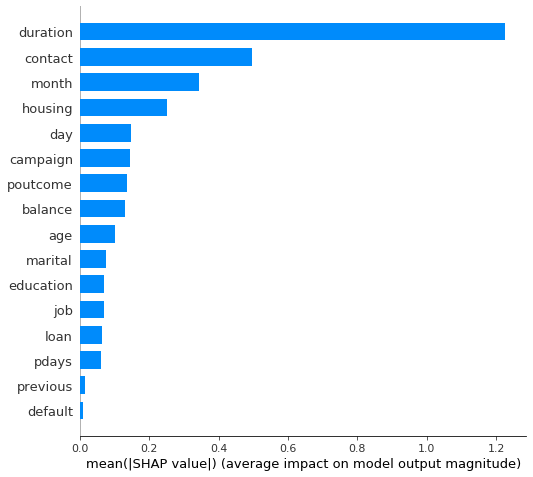

In [14]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

O atributo mais importante para o modelo predizer se a campanha terá sucesso ou não, é o tempo de duração dos contatos.

Agora eu faço um plot muito interessante, que no eixo X mostra o quanto cada ponto dos atributos afetou na classificação final pelo modelo (Mais para a esquerda afetou para classificar como não ter sucesso na campanha e mais para a direita, para ter sucesso) e também mostra através das cores, se o valor daquele ponto para cada atributo é alto o baixo.

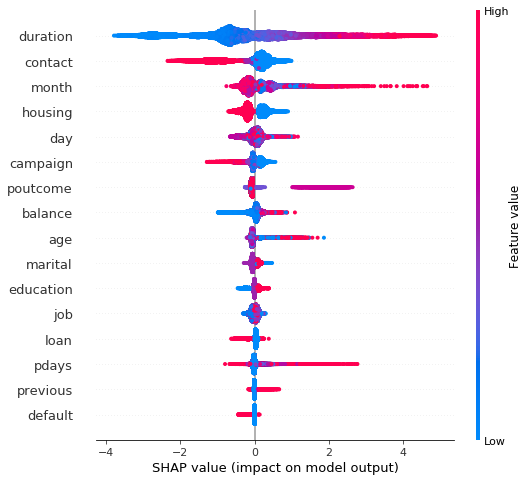

In [15]:
shap.summary_plot(shap_values[1], X)

Quanto maior o valor(vermelho) de campaign, mais o modelo tende a dizer que a previsão para este cliente vai ser de que ele não vai aceitar a proposta da campanha, e quanto menor o valor(azul), mais o modelo tende a dizer que a pessoa aceitará a oferta. Um ponto relevante a ser observado a partir destas informações é de que as pessoas que tendem a aceitar a oferta, fazem isso logo nos primeiros contatos. Talvez seja interessante para economizar recursos do departamento de marketing, direcionar os contatos apenas para pessoas que ainda não receberam nenhum ou receberam poucos contatos.

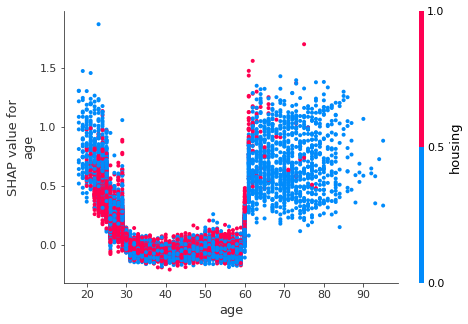

In [16]:
shap.dependence_plot('age', shap_values[1], X, display_features=X, interaction_index='housing')

In [29]:
X.iloc[0]

age            58
job             4
marital         1
education       2
default         0
balance      2143
housing         1
loan            0
contact         2
day             5
month           8
duration      261
campaign        1
pdays          -1
previous        0
poutcome        3
Name: 0, dtype: object

In [17]:
LGBM.predict(X)[0]

0.005490467976214369

In [18]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])

In [19]:
LGBM.predict(X)[2]

0.002156164598859255

In [20]:
shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], X.iloc[2,:])

In [21]:
LGBM.predict(X)[-1]

0.23542019841429127

In [22]:
shap.force_plot(explainer.expected_value[1], shap_values[1][-1,:], X.iloc[-1,:])

In [23]:
LGBM.predict(X)[-3]

0.6929061080143989

In [24]:
shap.force_plot(explainer.expected_value[1], shap_values[1][-3,:], X.iloc[-3,:])

Também podem ser usados para modelos de NLP

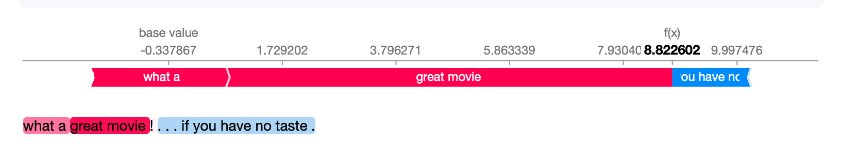

Também podem ser usados para redes neurais

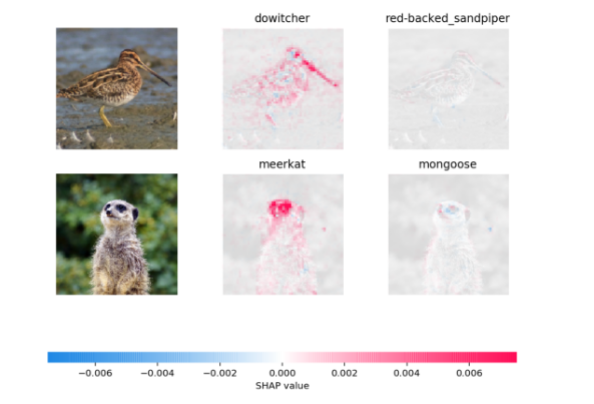